#### *TODO*
* ladders for internal ions
* save results to file
* gather statistics from multiple TSV lines
* documentation
* GitHub


* Спектр кластеры для лесенок (для каждого иона свой кластер)
* Для пиков, встречающихся в msalign собрать статистику, когда он детектируется и нет. Например, потери между пиками
* Пики, анонсирующиеся неоднозначно. Сколько коллизий?
* Выводить рядом с пиками погрешность
* Помотреть на ионы, видимые в mzXML, но не в msalign, есть ли дырки
* есть ли что-то общее у тех, которые определяются и нет? Наприер, он смотрит на заряд 1, но определяет, если есть кластеры (хороши), но для нескольких
* когда precursor mass = 0.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from pyteomics import mass, mzid
from pyteomics import mzxml
from bisect import bisect_left

In [2]:
def ind_in_mzxml(pep, mzxml_mz, prec, charges, isotopes):
    ''' Determine whether a given sequence appears in a given mzXML m/z's
    as b or internal ion, with given precision and numbers of charges and isotopes
    Returns (index, charge, isotope) or (False, False, False)'''
    for charge in range(1, charges + 1):
        for isot in range(isotopes):
            th_mz = mass.calculate_mass(sequence=pep, charge = charge, type='b') + isot/charge
            ind = bisect_left(mzxml_mz, th_mz - prec)
            if (ind >= 0 and ind < len(mzxml_mz)):
                mz = mzxml_mz[ind]
                if abs(mz - th_mz) < prec:
                    return (ind, charge, isot)
    return (False, False, False)

In [4]:
def extract_masses(scan, file):
    '''Ectract masses form given scan from msalign file'''
    lookup = 'SCANS=' + str(scan)
    pos = -1
    masses = []
    leng = 0
    for num, line in enumerate(file):
        leng += 1
        if lookup in line:
            pos = num
            break
    if (pos == -1):
        print('Oops, scan_id not found')
    else:
        pos += 1
        line = file.readline(pos)
        while ('PRECURSOR_MASS' not in line):
            pos += 1
            line = file.readline(pos)
        pos += 1
        line = file.readline(pos)
        while('END' not in line):
            masses.append(float(line.split('\t')[0]))
            pos += 1
            line = file.readline(pos)
    return masses

In [75]:
def extract_charge(scan, file):
    lookup = 'SCANS=' + str(scan)
    pos = -1
    charge = 0
    for num, line in enumerate(file):
        if lookup in line:
            pos = num
            break
    if (pos == -1):
        print(leng, 'Oops, scan_id not found')
    else:
        pos += 1
        line = file.readline(pos)
        while ('PRECURSOR_MASS=' not in line):
            pos += 1
            line = file.readline(pos)
        charge = float(line[len('PRECURSOR_MASS='): -1])
    return charge

In [7]:
def draw_ms(df, charges, isotopes, idx, save=False):
    '''Draw peaks from mzXML, corresponding to a given ion separetely for all charges'''
    fig = plt.figure(figsize=[2, 5], dpi=200)
    row = df.iloc[idx]
    cur = 1
    total = 0
    for c in range(charges):
        if len(row['M/z\'s'][c]):
            total += 1
#     if peptide:
#         plt.title('Isotopes of ' + peptide)
    for c in range(charges):
        mz = row['M/z\'s'][c]
        intens = row['Intensities'][c]
        if len(mz):
            ax = fig.add_subplot(total, 1, cur)
#             plt.subplot(5, 1, c+1)
            ax.set_title('Charge {}'.format(c+1), {'fontsize': 5})
            name = row['Ion name']
            typ= name[0]
            start = mass.calculate_mass(sequence=row['Ion sequence'], ion_type=typ, charge=c+1)
            step = 1 / (c + 1)
            ax.set_xlim(start - step / 5, start + (isotopes - 1 + 1/5) * step)
            ax.bar(x=mz, height=intens, width= start / 20000)
            plt.xticks(np.arange(start, start + (isotopes - 0.5) * step, step))
            for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(3)
            for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(3)
            cur += 1
    fig.subplots_adjust(hspace=1.2)
    fig.align_labels()
    if save:
        plt.savefig(save + '.png')
    plt.show()

### Как вычисляются массы b- и y-ионов?

In [26]:

print(mass.calculate_mass(sequence='G', charge=1),
      mass.calculate_mass(sequence='G', ion_type='b'),
      mass.calculate_mass(sequence='G', ion_type='y')
     )
# m = mass.calculate_mass(sequence='G', ion_type='b', charge=0)
# mz = mass.calculate_mass(sequence='G', ion_type='b', charge=2)
# print((m+2)/2, mz)
#TODO поискать внутренние объекты (суммировать массы, без добавок)
#внутренний как b

76.03930487103999 57.02146372057 75.03202840427


### Load data

In [9]:
%%time
#mzid - produced by msgf+
# Note
mzid_path = 'D:\\Биоинформатика\\Data\\Bottom-up CAH2\\Produced\\140411_QE_Cah-1.mzid'
# Comp
# mzid_path = 'C:\\Users\\Kirill\\Bioinf\\Data\\Bottom-up CAH2\\Produced\\140411_QE_Cah-1.mzid'
df = mzid.DataFrame(mzid_path)

#mzXML (raw)
mzxml_path = 'D:\\Биоинформатика\\Data\\Bottom-up CAH2\\Downloaded\\bottom-up-mzxml\\140411_QE_Cah-1.mzxml'
# mzxml_path = 'C:\\Users\\Kirill\\Bioinf\\Data\\Bottom-up CAH2\\Downloaded\\bottom-up-mzxml\\140411_QE_Cah-1.mzxml'
xml = mzxml.read(mzxml_path, use_index=True)

#msalign - produced by MS Deconv
msalign_path = 'D:\\Биоинформатика\\Data\\Bottom-up CAH2\\Downloaded\\bottom-up-msalign\\140411_QE_Cah-1_msdeconv.msalign'
# msalign_path = 'C:\\Users\\Kirill\\Bioinf\\Data\\Bottom-up CAH2\\Downloaded\\bottom-up-msalign\\140411_QE_Cah-1_msdeconv.msalign'
msalign = open(msalign_path, 'r')

print('Finished')

Finished
Wall time: 48 s


In [10]:
df.head()

,AssumedDissociationMethod,FileFormat,IsotopeError,MS-GF:DeNovoScore,MS-GF:EValue,MS-GF:RawScore,MS-GF:SpecEValue,Modification,PeptideSequence,SpectrumIDFormat,...,numDatabaseSequences,passThreshold,post,pre,protein description,rank,scan number(s),scan start time,spectrumID,start
0,HCD,FASTA format,0.0,316.0,1.505277e-34,313.0,1.878543e-38,NaN,MVNNGHSFNVEYDDSQDKAVLKDGPLTGTYR,scan number only nativeID format,...,33,True,L,R,[sp|P00921|CAH2_BOVIN Carbonic anhydrase 2 OS=...,1,7153.0,807.698,scan=7153,[59]
1,HCD,FASTA format,0.0,313.0,2.608684e-34,307.0,3.255565e-38,NaN,MVNNGHSFNVEYDDSQDKAVLKDGPLTGTYR,scan number only nativeID format,...,33,True,L,R,[sp|P00921|CAH2_BOVIN Carbonic anhydrase 2 OS=...,1,7098.0,802.337,scan=7098,[59]
2,HCD,FASTA format,0.0,279.0,2.459227e-33,267.0,3.069047e-37,NaN,HVGDLGNVTADKNGVAIVDIVDPLISLSGEYSIIGR,scan number only nativeID format,...,33,True,T,R,[gi|27807109|ref|NP_777040.1| superoxide dismu...,1,14280.0,1521.130,scan=14280,[79]
3,HCD,FASTA format,0.0,255.0,9.371177e-33,250.0,1.169497e-36,NaN,MVNNGHSFNVEYDDSQDKAVLKDGPLTGTYR,scan number only nativeID format,...,33,True,L,R,[sp|P00921|CAH2_BOVIN Carbonic anhydrase 2 OS=...,1,7131.0,805.562,scan=7131,[59]
4,HCD,FASTA format,0.0,342.0,1.189372e-32,330.0,1.484303e-36,NaN,MVNNGHSFNVEYDDSQDKAVLKDGPLTGTYR,scan number only nativeID format,...,33,True,L,R,[sp|P00921|CAH2_BOVIN Carbonic anhydrase 2 OS=...,1,7208.0,813.080,scan=7208,[59]


### Study MS DEconv performance on a low-EValue peptide

In [77]:
%%time
#precision, 0 for 10ppm
prec = 0

#choose a line from TSV
index = 1

#choose for how many isotopes to look (+0..+isotopes-1)
isotopes = 7

#choose for how many charges to look (+1..+charges)
charges = 5

#look for middle ions
look_for_internal = True
#initial length = 5  
ladder_threshold = 5
max_len_internal = 10

#get data from TSV (mzid) ('df')
data = df.iloc[index]
evalue = data['MS-GF:SpecEValue']
scan_id = int(data['scan number(s)'])
peptide = data['PeptideSequence']

if prec == 0:
    prec = 10 * mass.calculate_mass(sequence=peptide) / 1000000

#get masses from corresponding scan from msalign file ('msalign') specified
msalign.seek(0)
msalign_masses = extract_masses(scan=scan_id, file=msalign)
msalign_masses_sorted = sorted(msalign_masses)
msalign.seek(0)
msalign_charge = extract_charge(scan=scan_id, file=msalign)


# get m/z from mzXML file ('xml')
mzxml_mz = xml[scan_id - 1]['m/z array']
mzxml_intens = xml[scan_id - 1]['intensity array']

#make theoretical spectra
length = len(peptide)
# b_ions = [mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b') for i in range(length)]
b_ions_mz = [(mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b', charge=z) + isot / z,
              peptide[:i + 1],
              z,
              isot)
             for z in range(1, charges+1) for isot in range(0, isotopes) for i in range(length)]
b_ion_name = {mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b') : peptide[:i + 1] for i in range(length)}
# y_ions = [mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y') for i in range(length)]
y_ions_mz = [(mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y', charge=z) + isot / z,
              peptide[-i - 1:],
              z,
              isot)
             for z in range(1, charges+1) for isot in range(isotopes) for i in range(length)]
y_ion_name = {mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y') : peptide[-i - 1:] for i in range(length)}

bs = [{} for i in range(length)]
for i in range(length):
    bs[i]['name'] = peptide[:i + 1]
    bs[i]['type'] = 'b{}'.format(i + 1)
    bs[i]['mass'] = mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b')
    bs[i]['msalign'] = 0
    bs[i]['mzxml'] = 0
    bs[i]['mz'] = [[] for c in range(charges)]
    bs[i]['intens'] = [[] for c in range(charges)]
ys = [{} for i in range(length)]
for i in range(length):
    ys[i]['name'] = peptide[-i - 1:]
    ys[i]['type'] = 'y{}'.format(i + 1)
    ys[i]['mass'] = mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y')
    ys[i]['msalign'] = 0
    ys[i]['mzxml'] = 0
    ys[i]['mz'] = [[] for c in range(charges)]
    ys[i]['intens'] = [[] for c in range(charges)]

if look_for_internal:
    internals = [[{} for j in range(length)] for i in range(length)]
###     internals[k, l] means positions from k+2 >= 2 to k+l+1 <= length-1, so it's peptide[k+2:k+2+l]
    #internal ions: internals[i, j] stands for peptide[i:j] so it should be 1 <= i < j < length 
    for i in range(1, length - 1):
        for j in range(i + 1, length):
            internals[i][j]['name'] = peptide[i:j]
            internals[i][j]['type'] = 'int{}_{}'.format(i + 1, j)
            internals[i][j]['mass'] = mass.calculate_mass(sequence=peptide[i:j], ion_type='b')
            internals[i][j]['msalign'] = 0
            internals[i][j]['mzxml'] = 0
            internals[i][j]['mz'] = [[] for c in range(charges)]
            internals[i][j]['intens'] = [[] for c in range(charges)]


#find matches between theoretical and real spectra
print('Studying peptide {} with EValue {}'.format(peptide, evalue))
print('Peptide length: {}'.format(length))
print('Peptide mass: {}\n'.format(mass.calculate_mass(sequence=peptide)))
print('Looking at msalign data, scan={}:'.format(scan_id))
print('Charge: {}'.format(msalign_charge))
collisions_msalign = []
for mas in msalign_masses:
    for l, b in enumerate(bs):
        if abs(mas - b['mass']) < prec:
            collisions_msalign.append(('b', mas, b['mass'], b['name'], ()))
            bs[l]['msalign'] += 1
#             print('Mass {0:8.3f} looks like {1:8.3f} - mass of b-ion {2}'.format(mas, b, b_ion_name[b]))
    for l, y in enumerate(ys):
        if abs(mas - y['mass']) < prec:
            collisions_msalign.append(('y', mas, y['mass'], y['name'], ()))
            ys[l]['msalign'] += 1
#             print('Mass {0:8.3f} looks like {1:8.3f} - mass of y-ion {2}'.format(mas, y, y_ion_name[y]))
print('Total collisions: {}/{}\n'.format(len(collisions_msalign), len(msalign_masses)))

r = 0
print('Looking at mzXML data, scan={}'.format(scan_id))
max_isot = 0
collisions_xml = []
for b_mz, b_name, b_z, isotope in b_ions_mz:
    ind = bisect_left(mzxml_mz, b_mz - prec)
    collisions = 0
    if (ind >= 0 and ind < len(mzxml_mz)):
        mz = mzxml_mz[ind]
        if abs(mz - b_mz) < prec:
            collisions_xml.append((mz, b_mz, b_name, b_z, isotope))
            l = len(b_name)
            bs[l-1]['mzxml'] += 1
            bs[l-1]['mz'][b_z-1].append(mz)
            bs[l-1]['intens'][b_z-1].append(mzxml_intens[ind])
            if isotope == isotopes - 1:
                max_isot += 1
#             print('M/z {0:8.3f} looks like {1:8.3f} - m/z of b-ion {2} with charge {3}'.format(mz, b_mz, b_name, b_z))
for y_mz, y_name, y_z, isotope in y_ions_mz:
    ind = bisect_left(mzxml_mz, y_mz - prec)
    if (ind >= 0 and ind < len(mzxml_mz)):
        mz = mzxml_mz[ind]
        if abs(mz - y_mz) < prec:
            collisions_xml.append((mz, y_mz, y_name, y_z, isotope))
            l = len(y_name)
            ys[l-1]['mzxml'] += 1
            ys[l-1]['mz'][y_z-1].append(mz)
            ys[l-1]['intens'][y_z-1].append(mzxml_intens[ind])
            if isotope == isotopes - 1:
                max_isot += 1
#             print('M/z {0:8.3f} looks like {1:8.3f} - m/z of y-ion {2} with charge {3}'.format(mz, y_mz, y_name, y_z))

#find ladders
ladders = []
if look_for_internal:
    for start in range(1, length - 6):
        stop = start + 5
        count = 0
        ladder_stop = []
        for delta in range(-2, min(max_len_internal - 4, start)):
            ind2, charge2, isot2 = ind_in_mzxml(peptide[start - delta:stop], mzxml_mz, prec, charges, isotopes)
            if (charge2):
                ion_sequence = peptide[start - delta:stop]
                ion_seq_cent = '_'*(start - delta) + ion_sequence + '_'*(length - stop)
                ion_name = 'm{}-{}'.format(start - delta + 1, stop)
                mas = mass.calculate_mass(sequence=peptide[start - delta:stop], ion_type='b')
                insert = bisect_left(msalign_masses_sorted, mas - prec)
                in_msalign = int(insert >= 0 and insert < len(msalign_masses) and abs(mas - msalign_masses_sorted[insert]) < prec)
                m_z = mzxml_mz[ind2]
                intens = mzxml_intens[ind2]
                ladder_stop.append((ion_sequence, ion_seq_cent, ion_name, in_msalign, mas, m_z, intens))
                count += 1
        if (count >= ladder_threshold):
            ladders.append({'type': 'stop', 'pos': stop, 'ladder': ladder_stop})
        count = 0
        ladder_start = []
        for delta in range(-2, min(max_len_internal - 4, length - stop)):
            ind2, charge2, isot2 = ind_in_mzxml(peptide[start:stop + delta], mzxml_mz, prec, charges, isotopes)
            if (charge2):
                ion_sequence = peptide[start:stop + delta]
                ion_seq_cent = '_'*(start) + ion_sequence + '_'*(length - stop - delta)
                ion_name = 'm{}-{}'.format(start + 1, stop + delta)
                mas = mass.calculate_mass(sequence=peptide[start:stop + delta], ion_type='b')
                insert = bisect_left(msalign_masses_sorted, mas - prec)
                in_msalign = int(insert >= 0 and insert < len(msalign_masses) and abs(mas - msalign_masses_sorted[insert]) < prec)
                m_z = mzxml_mz[ind2]
                intens = mzxml_intens[ind2]
                ladder_start.append((ion_sequence, ion_seq_cent, ion_name, in_msalign, mas, m_z, intens))
                count += 1
        if (count >= ladder_threshold):
            ladders.append({'type': 'start', 'pos': start, 'ladder': ladder_start})

print('Total collisions: {}/{}'.format(len(collisions_xml), len(mzxml_mz)))
print('Maximal isotopes(+{}) found: {}'.format(isotopes - 1, max_isot))
if look_for_internal:
    print('Ladders found: {}'.format(len(ladders)))

lad = len(ladders)
d_l={'Ion sequence': [ladders[l]['ladder'][i][0] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
     'Ion sequence centered': [ladders[l]['ladder'][i][1] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
     'Ion name': [ladders[l]['ladder'][i][2] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
     'In msalign': [ladders[l]['ladder'][i][3] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
     'Mass': [ladders[l]['ladder'][i][4] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
     'M/z\'s': [ladders[l]['ladder'][i][5] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
     'Intensities': [ladders[l]['ladder'][i][6] for l in range(lad) for i in range(len(ladders[l]['ladder']))]}

d = {'Ion sequence': [bs[l]['name'] for l in range(length)] + [ys[l]['name'] for l in range(length)],
     'Ion sequence centered': [bs[l]['name'] + '_'*(length-len(bs[l]['name'])) for l in range(length)] +
                              ['_'*(length-len(ys[l]['name'])) + ys[l]['name'] for l in range(length)],
     'Ion name': [bs[l]['type'] for l in range(length)] + [ys[l]['type'] for l in range(length)],
     'In msalign': [bs[l]['msalign'] for l in range(length)] + [ys[l]['msalign'] for l in range(length)],
     'In mzXML': [bs[l]['mzxml'] for l in range(length)] + [ys[l]['mzxml'] for l in range(length)],
     'Mass': [mass.calculate_mass(sequence=bs[l]['name'], ion_type='b') for l in range(length)] + 
             [mass.calculate_mass(sequence=ys[l]['name'], ion_type='y') for l in range(length)],
     'M/z\'s': [bs[l]['mz'] for l in range(length)] + [ys[l]['mz'] for l in range(length)],
     'Intensities': [bs[l]['intens'] for l in range(length)] + [ys[l]['intens'] for l in range(length)]}
summary = pd.DataFrame(data=d)
df_ladders = pd.DataFrame(data=d_l)
print('Total number of unique internal ions: {}'.format(df_ladders['Ion name'].nunique()))
                                                     
identified = []
for i in range(len(summary)):
    i = summary.iloc[i]
    if i['In msalign']:
        identified.append(len(i['Ion sequence']))
print('\nLengths of ions, identified by MSDeconv: ', identified)

Studying peptide MVNNGHSFNVEYDDSQDKAVLKDGPLTGTYR with EValue 3.2555653e-38
Peptide length: 31
Peptide mass: 3469.62084673068

Looking at msalign data, scan=7098:
Charge: 1156.86778371875
Total collisions: 12/25

Looking at mzXML data, scan=7098
Total collisions: 434/1305
Maximal isotopes(+6) found: 34
Ladders found: 41
Total number of unique internal ions: 164

Lengths of ions, identified by MSDeconv:  [3, 5, 6, 7, 8, 9, 4, 5, 7, 8, 9, 10]
Wall time: 3.46 s


### Generate a summary

In [70]:
pd.set_option('display.max_rows', 100)  # or 1000
summary = summary[['Ion sequence centered', 'Ion sequence', 'Ion name', 'In msalign', 'In mzXML', 'Mass', "M/z's", 'Intensities']]
summary[['Ion sequence centered', 'Ion name', 'In msalign', 'In mzXML', 'Mass', "M/z's", 'Intensities']]

,Ion sequence centered,Ion name,In msalign,In mzXML,Mass,M/z's,Intensities
0,M______________________________,b1,0,0,131.040485,"[[], [], [], [], []]","[[], [], [], [], []]"
1,MV_____________________________,b2,0,0,230.108899,"[[], [], [], [], []]","[[], [], [], [], []]"
2,MVN____________________________,b3,1,7,344.151826,"[[345.15872, 346.16306, 347.15878, 348.15283, ...","[[275598.56, 49452.906, 10175.351, 12905.378, ..."
3,MVNN___________________________,b4,0,4,458.194754,"[[459.20612, 460.20776, 461.21222, 465.18365],...","[[141874.3, 29252.451, 10920.987, 25344.037], ..."
4,MVNNG__________________________,b5,1,6,515.216217,"[[516.2236, 517.2256, 518.2216, 519.2446, 522....","[[280059.88, 74963.055, 24913.857, 5524.2437, ..."
5,MVNNGH_________________________,b6,1,9,652.275129,"[[653.282, 654.2844, 655.2805, 656.28143, 657....","[[964654.8, 339652.0, 103898.625, 22604.99, 10..."
6,MVNNGHS________________________,b7,1,7,739.307158,"[[740.3145, 741.3175, 742.307, 743.31, 744.347...","[[672849.2, 248353.5, 92302.945, 34452.277, 94..."
7,MVNNGHSF_______________________,b8,1,8,886.375572,"[[887.3815, 888.3841, 889.3883, 890.38605], [4...","[[272016.94, 127685.48, 51305.273, 25377.771],..."
8,MVNNGHSFN______________________,b9,1,12,1000.418499,"[[1001.4251, 1002.423, 1003.4226, 1004.4302, 1...","[[528808.2, 301501.5, 129964.99, 50394.61, 858..."
9,MVNNGHSFNV_____________________,b10,0,11,1099.486913,"[[1100.4956, 1101.4957, 1102.4985, 1103.4894, ...","[[672052.94, 406304.84, 175265.33, 97361.13, 3..."


In [52]:
print(np.sum(np.array(summary[0:31]['In mzXML'])))
print(np.sum(np.array(summary[31:]['In mzXML'])))

210
224


In [71]:
idx = 36
print(summary.iloc[idx]['M/z\'s'])
print(summary.iloc[idx]['Intensities'])
#TODO до каких масс, внут. фрагменты, документация, сохранение в файл, контроль версий

[[710.39484, 711.3909, 716.3499], [357.21176, 358.2161], [], [], []]
[[47425.035, 10676.202, 10292.095], [28732.496, 4340.46], [], [], []]


### Plot spectra for a given ion

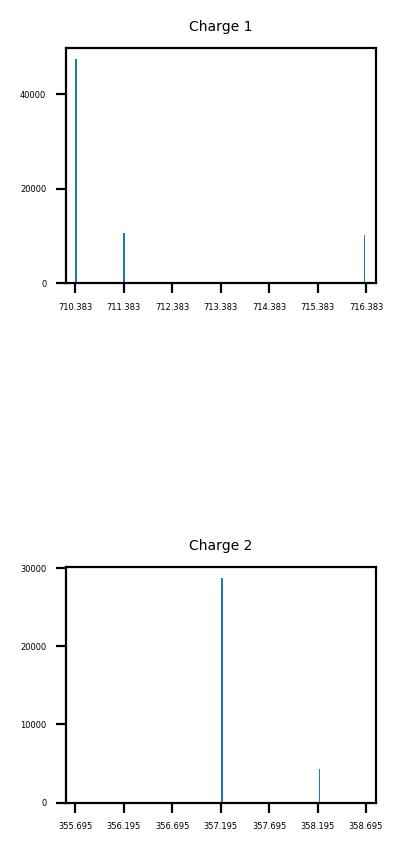

In [72]:
draw_ms(summary, charges=charges, isotopes=isotopes, idx=idx, save=False)

### Try to plot a spectra from mzXML

In [15]:
# mz = xml[scan_id - 1]['m/z array']
# intens = xml[scan_id - 1]['intensity array']
# mpl.rcParams['figure.figsize'] = [18, 18]
# mpl.rcParams['figure.dpi'] = 200
# plt.bar(x=mz, height=intens, width=0.9)
# plt.show()

In [54]:
pd.set_option('display.max_rows', 350)  # or 1000
print(df_ladders['Ion name'].nunique())
df_ladders[['Ion sequence centered', 'Ion name', 'In msalign', 'Mass', 'M/z\'s', 'Intensities']]

164


,Ion sequence centered,Ion name,In msalign,Mass,M/z's,Intensities
0,_VNN___________________________,m2-4,0,327.154269,346.163055,49452.906250
1,_VNNG__________________________,m2-5,0,384.175733,403.198395,5281.894043
2,_VNNGH_________________________,m2-6,0,521.234644,540.258179,5409.781738
3,_VNNGHS________________________,m2-7,0,608.266673,627.288086,121587.171875
4,_VNNGHSFN______________________,m2-9,0,869.378014,888.384094,127685.476562
5,_VNNGHSFNV_____________________,m2-10,0,968.446428,987.442200,27609.755859
6,_VNNGHSFNVE____________________,m2-11,0,1097.489021,1117.505981,178905.656250
7,__NNG__________________________,m3-5,0,285.107319,304.127563,6330.780762
8,__NNGH_________________________,m3-6,1,422.166230,441.183563,6398.783203
9,__NNGHS________________________,m3-7,0,509.198259,532.237610,9863.105469


### Turn all that into a function

In [17]:
def analyze(prec=0, index=0, isotopes=8, charges=5, look_for_internal=False, ladder_threshold=5, max_len_internal=10, out=None):
    '''precision=0 - in Da, 0 for 10ppm
    index=0 - line from TSV
    isotopes=8 - for how many isotopes to look (+0..+isotopes-1)
    charges=5 -  for how many charges to look (+1..+charges)
    look_for_internal = False - look for ladders of internal ions
    #initial length = 5  
    #looking from 3 to 9
    ladder_threshold=5 - show ladders with at least that many identified ions
    max_len_internal=10 - maximam length of internal ion in a ladder (min=3)'''

    #get data from TSV (mzid) ('df')
    data = df.iloc[index]
    evalue = data['MS-GF:SpecEValue']
    scan_id = int(data['scan number(s)'])
    peptide = data['PeptideSequence']

    if prec == 0:
        prec = 10 * mass.calculate_mass(sequence=peptide) / 1000000

    #get masses from corresponding scan from msalign file ('msalign') specified
    msalign.seek(0)
    msalign_masses = extract_masses(scan=scan_id, file=msalign)
    msalign_masses_sorted = sorted(msalign_masses)
    msalign.seek(0)
    msalign_charge = extract_charge(scan=scan_id, file=msalign)


    # get m/z from mzXML file ('xml')
    mzxml_mz = xml[scan_id - 1]['m/z array']
    mzxml_intens = xml[scan_id - 1]['intensity array']

    #make theoretical spectra
    length = len(peptide)
    # b_ions = [mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b') for i in range(length)]
    b_ions_mz = [(mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b', charge=z) + isot / z,
                  peptide[:i + 1],
                  z,
                  isot)
                 for z in range(1, charges+1) for isot in range(0, isotopes) for i in range(length)]
    b_ion_name = {mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b') : peptide[:i + 1] for i in range(length)}
    # y_ions = [mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y') for i in range(length)]
    y_ions_mz = [(mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y', charge=z) + isot / z,
                  peptide[-i - 1:],
                  z,
                  isot)
                 for z in range(1, charges+1) for isot in range(isotopes) for i in range(length)]
    y_ion_name = {mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y') : peptide[-i - 1:] for i in range(length)}

    bs = [{} for i in range(length)]
    for i in range(length):
        bs[i]['name'] = peptide[:i + 1]
        bs[i]['type'] = 'b{}'.format(i + 1)
        bs[i]['mass'] = mass.calculate_mass(sequence=peptide[:i + 1], ion_type='b')
        bs[i]['msalign'] = 0
        bs[i]['mzxml'] = 0
        bs[i]['mz'] = [[] for c in range(charges)]
        bs[i]['intens'] = [[] for c in range(charges)]
    ys = [{} for i in range(length)]
    for i in range(length):
        ys[i]['name'] = peptide[-i - 1:]
        ys[i]['type'] = 'y{}'.format(i + 1)
        ys[i]['mass'] = mass.calculate_mass(sequence=peptide[-i - 1:], ion_type='y')
        ys[i]['msalign'] = 0
        ys[i]['mzxml'] = 0
        ys[i]['mz'] = [[] for c in range(charges)]
        ys[i]['intens'] = [[] for c in range(charges)]

#     if look_for_internal:
#         internals = [[{} for j in range(length)] for i in range(length)]
#     ###     internals[k, l] means positions from k+2 >= 2 to k+l+1 <= length-1, so it's peptide[k+2:k+2+l]
#         #internal ions: internals[i, j] stands for peptide[i:j] so it should be 1 <= i < j < length 
#         for i in range(1, length - 1):
#             for j in range(i + 1, length):
#                 internals[i][j]['name'] = peptide[i:j]
#                 internals[i][j]['type'] = 'int{}_{}'.format(i + 1, j)
#                 internals[i][j]['mass'] = mass.calculate_mass(sequence=peptide[i:j], ion_type='b')
#                 internals[i][j]['msalign'] = 0
#                 internals[i][j]['mzxml'] = 0
#                 internals[i][j]['mz'] = [[] for c in range(charges)]
#                 internals[i][j]['intens'] = [[] for c in range(charges)]


    #find matches between theoretical and real spectra
    if out is not None:
        out.write('Studying peptide {} with EValue {}\n'.format(peptide, evalue))
        out.write('Peptide length: {}\n'.format(length))
        out.write('Peptide mass: {}\n\n'.format(mass.calculate_mass(sequence=peptide)))
        out.write('Looking at msalign data, scan={}:\n'.format(scan_id))
        out.write('Charge: {}\n'.format(msalign_charge))
    collisions_msalign = []
    for mas in msalign_masses:
        for l, b in enumerate(bs):
            if abs(mas - b['mass']) < prec:
                collisions_msalign.append(('b', mas, b['mass'], b['name'], ()))
                bs[l]['msalign'] += 1
    #             out.write('Mass {0:8.3f} looks like {1:8.3f} - mass of b-ion {2}'.format(mas, b, b_ion_name[b]))
        for l, y in enumerate(ys):
            if abs(mas - y['mass']) < prec:
                collisions_msalign.append(('y', mas, y['mass'], y['name'], ()))
                ys[l]['msalign'] += 1
    #             out.write('Mass {0:8.3f} looks like {1:8.3f} - mass of y-ion {2}'.format(mas, y, y_ion_name[y]))
    if out is not None:
        out.write('Total collisions: {}/{}\n\n'.format(len(collisions_msalign), len(msalign_masses)))

    r = 0
    if out is not None:
        out.write('Looking at mzXML data, scan={}\n'.format(scan_id))
    max_isot = 0
    collisions_xml = []
    for b_mz, b_name, b_z, isotope in b_ions_mz:
        ind = bisect_left(mzxml_mz, b_mz - prec)
        collisions = 0
        if (ind >= 0 and ind < len(mzxml_mz)):
            mz = mzxml_mz[ind]
            if abs(mz - b_mz) < prec:
                collisions_xml.append((mz, b_mz, b_name, b_z, isotope))
                l = len(b_name)
                bs[l-1]['mzxml'] += 1
                bs[l-1]['mz'][b_z-1].append(mz)
                bs[l-1]['intens'][b_z-1].append(mzxml_intens[ind])
                if isotope == isotopes - 1:
                    max_isot += 1
    #             out.write('M/z {0:8.3f} looks like {1:8.3f} - m/z of b-ion {2} with charge {3}'.format(mz, b_mz, b_name, b_z))
    for y_mz, y_name, y_z, isotope in y_ions_mz:
        ind = bisect_left(mzxml_mz, y_mz - prec)
        if (ind >= 0 and ind < len(mzxml_mz)):
            mz = mzxml_mz[ind]
            if abs(mz - y_mz) < prec:
                collisions_xml.append((mz, y_mz, y_name, y_z, isotope))
                l = len(y_name)
                ys[l-1]['mzxml'] += 1
                ys[l-1]['mz'][y_z-1].append(mz)
                ys[l-1]['intens'][y_z-1].append(mzxml_intens[ind])
                if isotope == isotopes - 1:
                    max_isot += 1
    #             out.write('M/z {0:8.3f} looks like {1:8.3f} - m/z of y-ion {2} with charge {3}'.format(mz, y_mz, y_name, y_z))

    #find ladders
    ladders = []
    if look_for_internal:
        for start in range(1, length - 6):
            stop = start + 5
            count = 0
            ladder_stop = []
            for delta in range(-2, min(max_len_internal - 4, start)):
                ind2, charge2, isot2 = ind_in_mzxml(peptide[start - delta:stop], mzxml_mz, prec, charges, isotopes)
                if (charge2):
                    ion_sequence = peptide[start - delta:stop]
                    ion_seq_cent = '_'*(start - delta) + ion_sequence + '_'*(length - stop)
                    ion_name = 'm{}-{}'.format(start - delta + 1, stop)
                    mas = mass.calculate_mass(sequence=peptide[start - delta:stop])
                    insert = bisect_left(msalign_masses_sorted, mas - prec)
                    in_msalign = int(insert >= 0 and insert < len(msalign_masses) and abs(mas - msalign_masses[insert]) < prec)
                    m_z = mzxml_mz[ind2]
                    intens = mzxml_intens[ind2]
                    ladder_stop.append((ion_sequence, ion_seq_cent, ion_name, in_msalign, mas, m_z, intens))
                    count += 1
            if (count >= ladder_threshold):
                ladders.append({'type': 'stop', 'pos': stop, 'ladder': ladder_stop})
            count = 0
            ladder_start = []
            for delta in range(-2, min(max_len_internal - 4, length - stop)):
                ind2, charge2, isot2 = ind_in_mzxml(peptide[start:stop + delta], mzxml_mz, prec, charges, isotopes)
                if (charge2):
                    ion_sequence = peptide[start:stop + delta]
                    ion_seq_cent = '_'*(start) + ion_sequence + '_'*(length - stop - delta)
                    ion_name = 'm{}-{}'.format(start + 1, stop + delta)
                    mas = mass.calculate_mass(sequence=peptide[start:stop + delta])
                    insert = bisect_left(msalign_masses_sorted, mas - prec)
                    in_msalign = int(insert >= 0 and insert < len(msalign_masses) and abs(mas - msalign_masses[insert]) < prec)
                    m_z = mzxml_mz[ind2]
                    intens = mzxml_intens[ind2]
                    ladder_start.append((ion_sequence, ion_seq_cent, ion_name, in_msalign, mas, m_z, intens))
                    count += 1
            if (count >= ladder_threshold):
                ladders.append({'type': 'start', 'pos': start, 'ladder': ladder_start})

    if out is not None:
        out.write('Total collisions: {}/{}\n'.format(len(collisions_xml), len(mzxml_mz)))
        out.write('Maximal isotopes(+{}) found: {}\n'.format(isotopes - 1, max_isot))
    if look_for_internal and out is not None:
        out.write('Ladders found: {}\n'.format(len(ladders)))

    lad = len(ladders)
    d_l={'Ion sequence': [ladders[l]['ladder'][i][0] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
         'Ion sequence centered': [ladders[l]['ladder'][i][1] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
         'Ion name': [ladders[l]['ladder'][i][2] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
         'In msalign': [ladders[l]['ladder'][i][3] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
         'Mass': [ladders[l]['ladder'][i][4] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
         'M/z\'s': [ladders[l]['ladder'][i][5] for l in range(lad) for i in range(len(ladders[l]['ladder']))],
         'Intensities': [ladders[l]['ladder'][i][6] for l in range(lad) for i in range(len(ladders[l]['ladder']))]}

    d = {'Ion sequence': [bs[l]['name'] for l in range(length)] + [ys[l]['name'] for l in range(length)],
         'Ion sequence centered': [bs[l]['name'] + '_'*(length-len(bs[l]['name'])) for l in range(length)] +
                                  ['_'*(length-len(ys[l]['name'])) + ys[l]['name'] for l in range(length)],
         'Ion name': [bs[l]['type'] for l in range(length)] + [ys[l]['type'] for l in range(length)],
         'In msalign': [bs[l]['msalign'] for l in range(length)] + [ys[l]['msalign'] for l in range(length)],
         'In mzXML': [bs[l]['mzxml'] for l in range(length)] + [ys[l]['mzxml'] for l in range(length)],
         'Mass': [mass.calculate_mass(sequence=bs[l]['name']) for l in range(length)] + 
                 [mass.calculate_mass(sequence=ys[l]['name']) for l in range(length)],
         'M/z\'s': [bs[l]['mz'] for l in range(length)] + [ys[l]['mz'] for l in range(length)],
         'Intensities': [bs[l]['intens'] for l in range(length)] + [ys[l]['intens'] for l in range(length)]}
    summary = pd.DataFrame(data=d)
    df_ladders = pd.DataFrame(data=d_l)
    if out is not None:
        out.write('Total number of unique internal ions: {}\n'.format(df_ladders['Ion name'].nunique()))

    identified = []
    ident_mas = np.array(summary[summary['In msalign'] > 0]['Mass'])
    for i in range(len(summary)):
        i = summary.iloc[i]
        if i['In msalign']:
            identified.append(len(i['Ion sequence']))
    if out is not None:
        out.write('\nLengths of ions, identified by MSDeconv: ' + str(identified) + '\n')
        out.write(summary[['Ion sequence centered', 'Ion name', 'In msalign', 'In mzXML', 'Mass']].to_csv(sep='\t'))
    
    return ident_mas

### Output in a file

In [18]:
%%time
# out = open('testfile.txt', 'w')
# a = analyze(out=out)
# out.close()
# print(a)

Wall time: 0 ns


### Analyze multiple lines and accumulate all masses of identified ions

In [19]:
%%time
# all_masses = []
# for i in range(100):
#     all_masses += list(analyze(index=i))
# print(all_masses)

Wall time: 0 ns


In [20]:
# plt.hist(all_masses)
# plt.savefig('Identified masses histogram.png')
# plt.show()
np.sum(np.array(all_masses) > 1500)/len(all_masses)

NameError: name 'all_masses' is not defined

In [ ]:
len(df)